# understanding CU pair reactivity trends

# Summary

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, ttest_ind
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from tabulate import tabulate
import py3Dmol

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    plot_motif_boxplot_stripplot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
    format_small_plot,
)
from dms_3d_features.format_tables import (
    dataframe_column_table,
    generate_threshold_summary,
)
from dms_3d_features.stats import r2, check_pairwise_statistical_significance

## extra functions

In [3]:
def visualize_molecule(row, width=400, height=300):
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(open("../" + row["pdb_path"], "r").read(), "pdb")

    # Set color scheme for nucleotides
    nucleotide_colors = {"A": "red", "U": "green", "C": "blue", "G": "orange"}
    for nuc, color in nucleotide_colors.items():
        viewer.setStyle({"resn": nuc}, {"stick": {"color": color}})

    viewer.zoomTo()

    residue_number = row["pdb_r_pos"]
    viewer.addStyle({"resi": str(residue_number)}, {"stick": {"color": "magenta"}})

    # Highlight N1 for A or N3 for C
    if row["r_nuc"] == "A":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N1"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )
    elif row["r_nuc"] == "C":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N3"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )

    return viewer

### plotting

In [4]:
def plot_residue_trends(df, color="tab:gray", col="ln_r_data"):
    fig = plt.figure(figsize=(3.0, 3.0), dpi=200)
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])

    # 5' Residue
    data_range = df[col].max() - df[col].min()
    extra_space = 0.4 * data_range
    xlim_min = df[col].min() - extra_space
    xlim_max = df[col].max()

    plot_violins_w_percent(
        df,
        col,
        "p5_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax1,
    )
    ax1.set_ylabel("5' Residue", labelpad=2)
    ax1.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax1)

    # 3' Residue
    plot_violins_w_percent(
        df,
        col,
        "p3_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax2,
    )
    ax2.set_ylabel("3' Residue", labelpad=2)
    ax2.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax2)

    # Residue Stack
    plot_violins_w_percent(
        df,
        col,
        "r_stack",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax3,
    )
    ax3.set_ylabel("Residue Stack", labelpad=2)
    ax3.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax3)
    plt.tight_layout()

In [5]:
def plot_flanking_pairs_distribution(df):
    # Combine the flanking pairs into a single column
    df["flanking_pairs"] = df["m_second_flank_bp_5p"] + "-" + df["m_second_flank_bp_3p"]
    # Calculate mean r_data_ratio for each flanking pair
    mean_r_data_ratio = (
        df.groupby("flanking_pairs")["r_data_ratio"].mean().sort_values(ascending=False)
    )
    # Create the rotated violin plot
    plt.figure(figsize=(5, 4))
    sns.violinplot(
        x="r_data_ratio",
        y="flanking_pairs",
        data=df,
        order=mean_r_data_ratio.index[::-1],
        cut=0,
        orient="h",
        density_norm="width",
    )
    # Customize the plot
    plt.title("Distribution of r_data_ratio for Different Flanking Pairs")
    plt.xlabel("r_data_ratio")
    plt.ylabel("Flanking Pairs (5' - 3')")
    # Add count labels
    counts = df["flanking_pairs"].value_counts()
    for i, flanking_pair in enumerate(mean_r_data_ratio.index[::-1]):
        count = counts[flanking_pair]
        plt.text(plt.xlim()[1] + 0.5, i, f"n={count}", ha="left", va="center")

### summary tables

In [6]:
def create_summary_table(df, y_column):
    # Calculate percentages and counts
    summary = []
    for y_value in df[y_column].unique():
        group = df[df[y_column] == y_value]
        percent_over = (group["ln_r_data"] < -5.45).mean() * 100
        count = len(group)
        summary.append([y_value, f"{percent_over:.2f}%", count])

    # Sort by percentage descending
    summary.sort(key=lambda x: float(x[1][:-1]), reverse=True)

    # Create table
    headers = [y_column, "% Under -5.45", "Count"]
    table = tabulate(summary, headers=headers, tablefmt="pipe", floatfmt=".2f")

    print(f"Summary table for {y_column}:")
    print(table)

In [7]:
def analyze_flanking_pairs(df):
    # Calculate the mean of r_data_ratio for each combination of m_second_flank_bp_5p and m_second_flank_bp_3p
    mean_r_data_ratio = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])["r_data_ratio"]
        .mean()
        .reset_index()
    )
    # Pivot the table to create a matrix-like structure
    pivot_table = mean_r_data_ratio.pivot(
        index="m_second_flank_bp_5p",
        columns="m_second_flank_bp_3p",
        values="r_data_ratio",
    )
    # Sort the index and columns alphabetically
    pivot_table = pivot_table.sort_index().sort_index(axis=1)
    # Display the results as a styled table
    display(pivot_table.style.format("{:.1f}").background_gradient(cmap="YlOrRd"))
    # Calculate the count of occurrences for each combination
    count_table = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])
        .size()
        .reset_index(name="count")
    )
    pivot_count = count_table.pivot(
        index="m_second_flank_bp_5p", columns="m_second_flank_bp_3p", values="count"
    )
    pivot_count = pivot_count.sort_index().sort_index(axis=1)
    # Display the count table
    display(pivot_count.style.format("{:.1f}").background_gradient(cmap="Blues"))

### misc

In [8]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

In [9]:
def add_side_diff_column(df):
    df["side_diff"] = [
        abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df["m_token"]
    ]
    df["side_diff"] = df["side_diff"].astype(str)
    return df

## load data

In [10]:
DATA_PATH = "../data"

In [12]:
df_constructs = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_cu = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU'").copy()
# pdb dataframe
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
df_pdb_cu = df_pdb.query(
    "r_nuc == 'U' and r_type == 'NON-WC' and pdb_r_pair == 'C-U' and no_of_interactions == 1"
).copy()

In [13]:
dataframe_column_table(df_pdb)

                         0                    1                   2                  3
                m_sequence                r_nuc           pdb_r_pos             r_type
             pdb_r_bp_type           pdb_r_pair no_of_conformations no_of_interactions
no_of_partner_interactions             pdb_name            pdb_path            pdb_res
               both_purine      both_pyrimidine          constructs        likely_pair
             m_flank_bp_5p        m_flank_bp_3p       m_orientation              m_pos
      m_second_flank_bp_5p m_second_flank_bp_3p         m_structure            m_token
                    n_pdbs            pair_type              p5_res            p5_type
                    p3_res              p3_type              r_data          r_loc_pos
                     r_pos              r_stack           ln_r_data            z_score
            r_data_outlier                  NaN                 NaN                NaN


# All residues

## percent under -5.45

In [14]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
print(len(df_cc["m_sequence"].unique()))

85


In [15]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
generate_threshold_summary(df_cc, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| C       | 6.72%       |   14564 |


In [16]:
df_cc = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC' and m_token == '1x1'"
).copy()
generate_threshold_summary(df_cc, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| C       | 0.89%       |     672 |


## Stacking trends

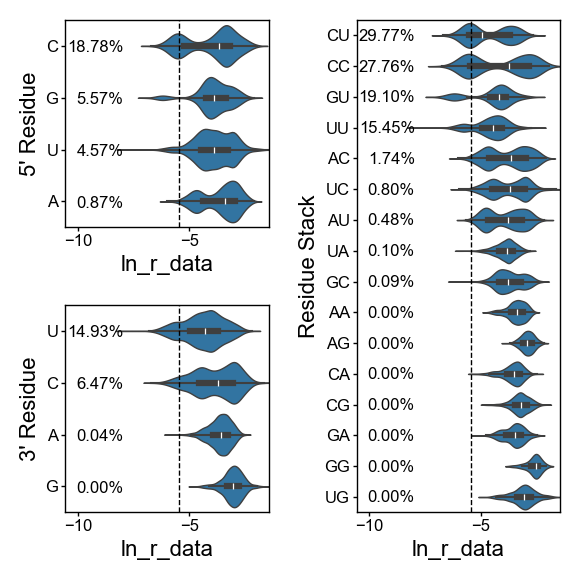

In [18]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
plot_residue_trends(df_cc, color="tab:blue")

In [19]:
# Example usage:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
p_values_df = check_pairwise_statistical_significance(df_cc, "r_stack", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
119,UG,UU,0.000000e+00
41,AG,UU,0.000000e+00
14,AA,UU,0.000000e+00
38,AG,UA,0.000000e+00
33,AG,CU,7.402265e-256
...,...,...,...
102,GC,UC,2.206930e-02
91,CU,UU,3.609717e-02
57,CA,GA,9.819420e-02
26,AC,UC,5.674827e-01


In [20]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
p_values_df = check_pairwise_statistical_significance(df_cc, "p5_res", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
0,A,C,2.812584e-65
2,A,U,9.839520e-58
1,A,G,1.671999e-29
3,C,G,5.921122e-09
4,C,U,1.995767e-08
5,G,U,2.092751e-01


In [21]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
p_values_df = check_pairwise_statistical_significance(df_cc, "p3_res", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
2,A,U,0.000000e+00
3,C,G,0.000000e+00
5,G,U,0.000000e+00
1,A,G,7.774457e-284
4,C,U,9.100448e-170
0,A,C,1.014701e-37


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


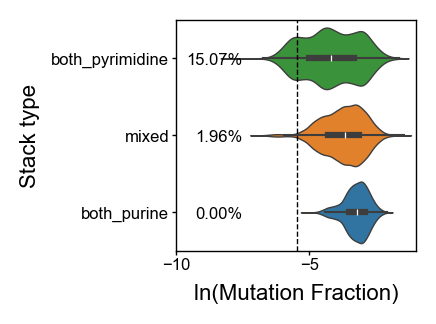

In [22]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
df_cc["stack_type"] = df_cc.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_cc,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

In [23]:
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
create_summary_table(df_cc, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 29.77%          |     813 |
| CC        | 27.76%          |    1275 |
| GU        | 19.10%          |     555 |
| UU        | 15.45%          |    1437 |
| AC        | 1.74%           |    1835 |
| UC        | 0.80%           |    2011 |
| AU        | 0.48%           |    1047 |
| UA        | 0.10%           |    1035 |
| GC        | 0.09%           |    1105 |
| AA        | 0.00%           |     839 |
| GA        | 0.00%           |     232 |
| AG        | 0.00%           |     522 |
| CA        | 0.00%           |     726 |
| CG        | 0.00%           |     360 |
| UG        | 0.00%           |     744 |
| GG        | 0.00%           |      28 |


# single mismatches

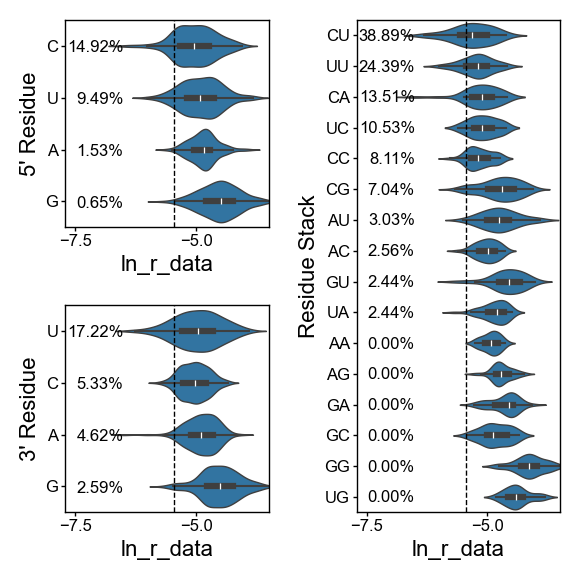

In [29]:
df_cu_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU' and m_token == '1x1'"
).copy()
plot_residue_trends(df_cu_1x1, color="tab:blue")

In [30]:
create_summary_table(df_cu_1x1, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 38.89%          |      36 |
| UU        | 24.39%          |      41 |
| CA        | 13.51%          |      37 |
| UC        | 10.53%          |      38 |
| CC        | 8.11%           |      37 |
| CG        | 7.04%           |      71 |
| AU        | 3.03%           |      33 |
| AC        | 2.56%           |      39 |
| GU        | 2.44%           |      41 |
| UA        | 2.44%           |      41 |
| AA        | 0.00%           |      21 |
| AG        | 0.00%           |      38 |
| UG        | 0.00%           |      38 |
| GG        | 0.00%           |      46 |
| GA        | 0.00%           |      31 |
| GC        | 0.00%           |      36 |


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


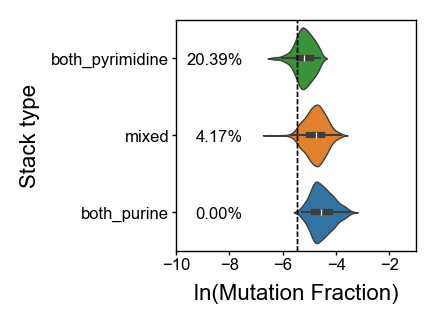

In [31]:
df_cu_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU' and m_token == '1x1'"
).copy()
df_cu_1x1["stack_type"] = df_cu_1x1.apply(assign_stack_type, axis=1)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = plot_violins_w_percent(
    df_cu_1x1,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

# 2x2 double mismatches

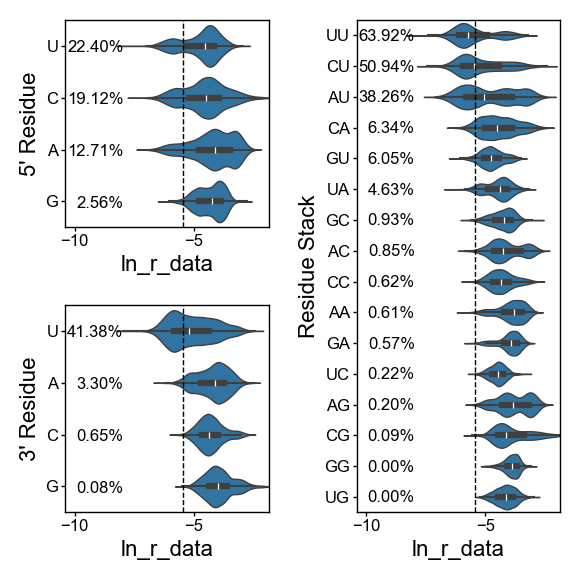

In [32]:
df_cu_2x2 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU' and m_token == '2x2'"
).copy()
plot_residue_trends(df_cu_2x2, color="tab:blue")

In [41]:
create_summary_table(df_cu_2x2, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| UU        | 63.92%          |    1577 |
| CU        | 50.94%          |    1961 |
| AU        | 38.26%          |    1686 |
| CA        | 6.34%           |    1261 |
| GU        | 6.05%           |    1388 |
| UA        | 4.63%           |     864 |
| GC        | 0.93%           |    1182 |
| AC        | 0.85%           |    1413 |
| CC        | 0.62%           |    1293 |
| AA        | 0.61%           |    1149 |
| GA        | 0.57%           |     700 |
| UC        | 0.22%           |    1359 |
| AG        | 0.20%           |     994 |
| CG        | 0.09%           |    1175 |
| GG        | 0.00%           |     600 |
| UG        | 0.00%           |     892 |


# with PDB info with known pairs

## stacking

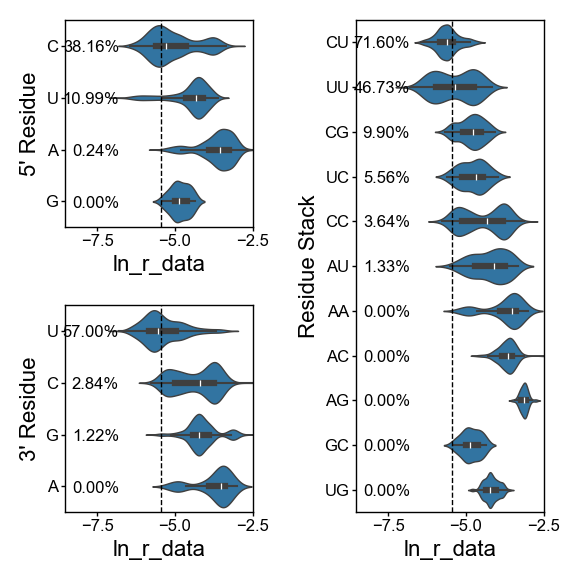

In [35]:
df_pdb_cu = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-U' and no_of_interactions == 1"
).copy()
plot_residue_trends(df_pdb_cu, color="tab:blue")

In [36]:
create_summary_table(df_pdb_cu, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 71.60%          |     426 |
| UU        | 46.73%          |     199 |
| CG        | 9.90%           |     101 |
| UC        | 5.56%           |      72 |
| CC        | 3.64%           |     330 |
| AU        | 1.33%           |      75 |
| AA        | 0.00%           |     120 |
| AC        | 0.00%           |     126 |
| AG        | 0.00%           |     104 |
| GC        | 0.00%           |      36 |
| UG        | 0.00%           |     612 |


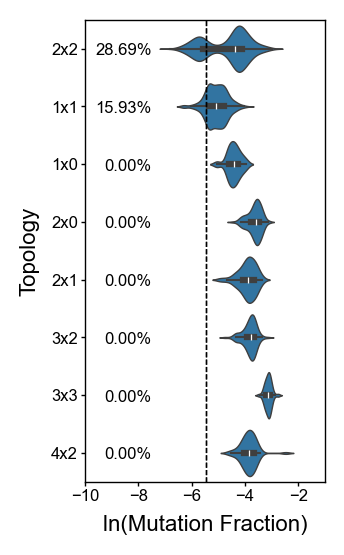

In [37]:
fig, ax = plt.subplots(figsize=(2.0, 3.0), dpi=200)
ax = plot_violins_w_percent(
    df_pdb_cu,
    "ln_r_data",
    "m_token",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Topology")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

In [38]:
df_pdb_cu.query("m_token.isnull()")

,m_sequence,r_nuc,pdb_r_pos,r_type,pdb_r_bp_type,pdb_r_pair,no_of_conformations,no_of_interactions,no_of_partner_interactions,pdb_name,...,p5_type,p3_res,p3_type,r_data,r_loc_pos,r_pos,r_stack,ln_r_data,z_score,r_data_outlier


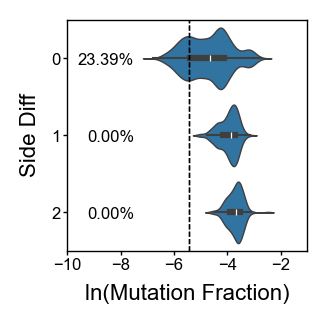

In [40]:
df_pdb_cu = df_pdb_cu.query("not m_token.isnull()")
df_pdb_cu = df_pdb_cu.query("m_token != '6x3'")
df_pdb_cu.query("m_token.isnull()")
df_pdb_cu = add_side_diff_column(df_pdb_cu)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = plot_violins_w_percent(
    df_pdb_cu,
    "ln_r_data",
    "side_diff",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Side Diff")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)